# **Práctica 5 - Sistemas de recomendación**
### **Miguel Carreras Lahoz y Adrián Rubio Pintado**

# **Exploración y Lectura del Dataset**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd "drive/MyDrive/cf-dataset"

/content/drive/MyDrive/cf-dataset


#### **Cálculo de valores nulos por usuario**

En el conjunto de train/test ya están eliminados los usuarios sin ninguna valoración. Aún así vamos a ver que porcentaje de valores nulos tenemos por usuario en los conjuntos de train/test.

In [4]:
# Usaremos la matriz de entrenamiento para entrenar
mat_train = pd.read_csv('training-matrix.dat',sep='\t')
print('Porcentaje de ratings no calificados del conjunto total por usuario:')
mat_train.isna().sum()/150 #Para obtener el porcentaje de NO VALORACIONES

Porcentaje de ratings no calificados del conjunto total por usuario:


item    0.000000
0       0.360000
1       0.200000
2       0.540000
3       0.473333
4       0.573333
5       0.746667
6       0.653333
7       0.620000
8       0.600000
11      0.726667
12      0.620000
13      0.646667
14      0.600000
15      0.713333
17      0.613333
18      0.733333
19      0.686667
21      0.553333
dtype: float64

In [5]:
# Usaremos la matriz de entrenamiento para entrenar
mat_test = pd.read_csv('test-matrix.dat',sep='\t')
print('Porcentaje de ratings no calificados del conjunto total por usuario:')
mat_test.isna().sum()/150 #Para obtener el porcentaje de NO VALORACIONES

Porcentaje de ratings no calificados del conjunto total por usuario:


item    0.000000
0       0.620000
1       0.580000
2       0.660000
3       0.646667
4       0.673333
5       0.713333
6       0.693333
7       0.680000
8       0.673333
11      0.706667
12      0.680000
13      0.686667
14      0.680000
15      0.706667
17      0.680000
18      0.713333
19      0.700000
21      0.666667
dtype: float64

## **EJERCICIO 1:**
**Aplicar un algoritmo de filtrado colaborativo basado en memoria para generar recomendaciones de películas para cada estudiante. Aplicarlo utilizando las puntuaciones de entrenamiento como base para recomendar películas del conjunto de test, y observar el nivel de acierto.** 


EL filtrado colaborativo  KNN basado en memoria presenta dos variantes principales: basado en usuario y basado en item. Elegimos el algoritmo de KNN basado en usuarios para poder ver la afinidad de gustos entre películas con nuestros compañeros.


### **KNN Basado en usuario:** 
Deseamos recomendar a un usuario $u$ los ítems  puntuados por usuarios vecinos $v$ "similares" a $u$. Tenemos dos opciones principales de formualización en este caso:

  $$\hat{r}(u,x) =\bar{r}(u)+c \sum_{v \in \eta_k(u)} sim(u,v)(r(v,x)-\bar{r}(v))$$ 

**Escogemos esta variante,** de modo que cuando para un item, ninguno del top k vecinos del usuario lo haya puntuado, se devuelva **la media del propio usuario.** **También para cuando solo hay un único vecino que lo haya puntuado,** de este modo  le damos estabilidad a la recomendación, y no "falseamos" de algún modo las métricas.
Además cabe destacar que **estamos centrando los ratings de cada vecino con su media, para que la desviacíon de la recomenación sea de nuevo más estable**  y no depende de los sesgos de puntuación de los vecinos, especialmente cuando son pocos.
  
Siendo $c$ una constante de normalización tal que 
$$ c = \frac{1}{\sum_{v \in \eta_k(u)}|sim(u,v)|} $$
I(v) el conjunto de items puntuados por un usuario $v$:
$$ I(v) = \{y \in I | r(v,y) \neq ∅\} $$

y $η_{k}(u)$ el top K vecinos más parecidos al usuario u:

$$η_{k}(u) = top(k, sim(u,.), U)$$


### **Función de Similitud**
La similitud entre dos usuarios u,v la podemos formalizar de dos modos: con la función coseno o con la correlación de Pearson.

   siendo $r(u),r(v)$ funciones de   ratings de los usuarios u y v.
   **Vamos a implementar ambas**
1. **Similitud Coseno.**
  Cuya formalización matemática queda tal que así:
  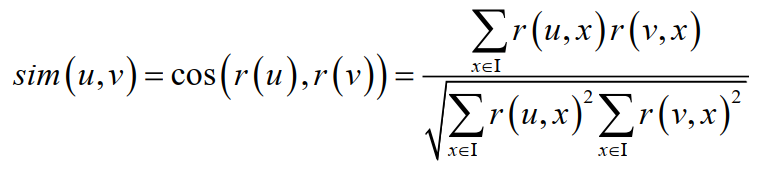


2. **Correlación de Pearson.**
  Su formalización queda tal que la similitud coseno sólo que restamos la media:
  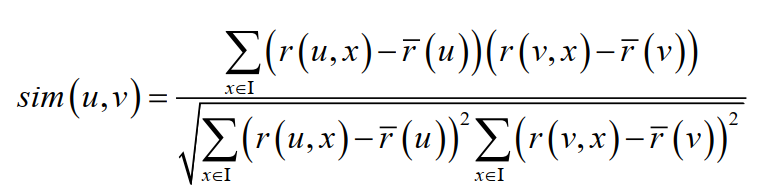


**Dado que en la práctica los sumatorios se suelen hacer sobre la intersección $x \in I(u) \cap I (v)$, nosotros la usaremos también en vez de sólo sobre $x \in I$**

#### Otras consideraciones adicionales:
  Cabe destacar que a la hora de recomendar un item a un usuario,**comprobamos que ese usuario no lo haya visto ya**,es decir, que no haya puntuado al item en el conjunto de train. No tendría ningún sentido una recomendación de algo que el usuario ya ha visto y puntuado.

  Además cuando no encontramos un número de vecinos mínimos especificado, no recomendamos y mostramos un mensaje de error. **Es decir, si un usuario no tiene vecinos, la recomendación dada no tiene ningún sentido, y no la proporcionamos.**


### **Implementación**

In [48]:
import itertools
import numpy as np
import copy

class user_KNN():

  def __init__(self, mat_ratings_train, sim_fun = 'cos' ):
    '''
      Precalculamos la matriz de similitudes y la media de ratings
      sim_fun = 'cos' o 'pearson'
    '''

    self.sim_fun = sim_fun
    self.mat_ratings = copy.deepcopy(mat_ratings_train)

    self.users = mat_ratings_train.columns.to_list()[1:]#quitamos columna' item'
    #Inicializamos la similitud a -infinito
    self.sim = {} #{(u,v):sim_value}
    self.I = {u: mat_train[~mat_train[u].isnull()].index.to_list() for u in self.users} #{u: I(u)= index of item} 
    self.user_rating_mean = {u:np.mean(mat_train[~mat_train[u].isnull()][u].to_list()) for u in self.users} # {u:user_mean_rating}
    
    # Calculating sim between users
    for u,v in list(itertools.combinations(self.users, 2)):
      if(sim_fun == 'cos'):
        self.sim[(u,v)] = self._calc_sim_cos_u_v(u,v)
      else:#pearson
        self.sim[(u,v)] = self._calc_pearson_cos_u_v(u,v)

    
    #print('self.sim', self.sim)


  def _calc_sim_cos_u_v(self, u, v):
    I_u = self.I[u]
    I_v = self.I[v]
    intersec_I_u_v = set(I_u).intersection(I_v)

    if(len(intersec_I_u_v)  == 0):#no ratings in commmon
      return 0.

    num = np.sum([ self.mat_ratings[u][x]  * self.mat_ratings[v][x]   for x in intersec_I_u_v ])
    denom_aux_1 = np.sum([ (self.mat_ratings[u][x])**2  for x in intersec_I_u_v ])
    denom_aux_2 = np.sum([ (self.mat_ratings[v][x])**2  for x in intersec_I_u_v ])
    denom = np.sqrt(denom_aux_1 * denom_aux_2)
    if(denom !=0):
      return num/denom
    else:
      return 0


  def _calc_pearson_cos_u_v(self, u, v):  
    I_u = self.I[u]
    I_v = self.I[v]
    intersec_I_u_v = set(I_u).intersection(I_v)

    num = np.sum([ (self.mat_ratings[u][x] - self.user_rating_mean[u])  * (self.mat_ratings[v][x] - self.user_rating_mean[v])   for x in intersec_I_u_v ])
    denom_aux_1 = np.sum([ (self.mat_ratings[u][x] - self.user_rating_mean[u])**2  for x in intersec_I_u_v ])
    denom_aux_2 = np.sum([ (self.mat_ratings[v][x]- self.user_rating_mean[v])**2  for x in intersec_I_u_v ])
    denom = np.sqrt(denom_aux_1 * denom_aux_2)
    if(denom !=0):
      return num/denom
    else:
      return 0


  def _get_sim_u_v(self,u,v):
    
    if(int(u)<int(v)):
      return self.sim[(u,v)]
    else:
      return self.sim[(v,u)]

  def _get_top_k_neighbours(self, u, k):
    neighbours = self.users
    neighbours.remove(u)
    ranking = [(v, self._get_sim_u_v(u,v) )   for v in neighbours]

    for t in ranking[0:k]:#check that we have neighbours enough!
      _, score = t
      if(score ==0.):
        print('WARNING: There is not ', k , 'neighbourds for this user, try a smaller value for k')
        return  []
    ranking_sorted = sorted(ranking, key=lambda x: x[1],reverse = True)
    top = [v for v,score in ranking_sorted]

    return top[0:k]


  def _get_score_u_x(self, u,x,c,top_k_neighbours, norm = True):
    '''Calcula el score de un item para el usuario u segú los ratings de sus top k vecinos
        norm = True si usamos la implementacion centrando ratings en la media
    '''

    #neigh_ratings = [ 0. if np.isnan(self.mat_ratings[v][x]) else self.mat_ratings[v][x]  for v in top_k_neighbours]
    neigh_ratings = [  self.mat_ratings[v][x]  for v in top_k_neighbours]

    #Si no hay ningún vecino que haya puntuado ese item O SOLO UN VECINO
    # obviamos la puntuación el item
    if(np.isnan(neigh_ratings).all() or (np.isnan(neigh_ratings).sum() == 1)): 
        neigh_ratings = [0.  for v in top_k_neighbours] 
        #devolviendo únicamente la media del propio usuario u 
        #de acuerdo a la expresion de abajo

    neigh_ratings = [  0. if np.isnan(r) else  r for r in neigh_ratings] #Limpiamos los nan's 
    if(norm):
      return self.user_rating_mean[u] +  c * np.sum([self._get_sim_u_v(u,v) * (r - self.user_rating_mean[v]) for v,r in zip(top_k_neighbours, neigh_ratings  ) ]) #centrando en la media
    else:
      return  c * np.sum([self._get_sim_u_v(u,v) * (r) for v,r in zip(top_k_neighbours, neigh_ratings  ) ]) #no centrando ratings en la media



  def recommend(self, u, k = 3, n_items = 5,verbosse = False, norm = True):
    ''' REcommends n_items items for user u with k neighbours
      u = user to recommend items
      k = number of neighbours
      n_items = number of items to be recommended
      norm = True si usamos la implementacion centrando ratings en la media
    '''
    
    top_k_neighbours = self._get_top_k_neighbours( u, k)
    if(not top_k_neighbours): return None
    c = 1 / np.sum([np.abs(self._get_sim_u_v(u,v)) for v in top_k_neighbours] )
    items = self.mat_ratings.index.to_list()
    u_items_ya_vistos =  set(self.mat_ratings[~self.mat_ratings[u].isnull()].index.to_list()) #ELIMINAMOS los items YA VISTOS
    ranking_items = [(x, self._get_score_u_x(u,x,c,top_k_neighbours, norm = norm) )  for x in items if x not in u_items_ya_vistos]
    ranking_items =  sorted(ranking_items, key=lambda x: x[1],reverse = True)
    if(verbosse):
      print('Sim function:', self.sim_fun)
      print('Recommendation for user ', u , ':')
    return ranking_items[:n_items]


  def predict(self, u,x, k = 3, verbosse = False):
    ''' Predicts ratings for x item and  user u with k neighbours
      u = user to recommend items
      x: item
      k = number of neighbours
    '''

    top_k_neighbours = self._get_top_k_neighbours( u, k)
    if(not top_k_neighbours):
      print('Err')
      return 0. 
    c = 1 / np.sum([np.abs(self._get_sim_u_v(u,v)) for v in top_k_neighbours] )
    return self._get_score_u_x(u,x,c,top_k_neighbours) 

    '''
    if(verbosse):
      print('Sim function:', self.sim_fun)
      print('Recommendation for user ', u , ':')
    return ranking_items[:n_items]
    '''


  def call_precision_recall(self,mat_test, k=3,rel_score_min = 3, n = 10, verbosse = True, norm = True):
    '''Calcula precision y recall @n para un número de vecinos k. Se promedia 
        sobre las predicciones para cada uno de los usuarios usando la matriz de test
        Para considerar un item como relevante debe de tener al menos una puntuacion de 
        rel_score_min
        norm = True si usamos la implementacion centrando ratings en la media
    '''

    precisions = []
    recalls = []

    for u in self.users:  
      u_ratings_nonull = mat_test[~mat_test[u].isnull()][u]
      u_relevantes =set( u_ratings_nonull.loc[u_ratings_nonull >= rel_score_min].to_list() )  # relevant items for u
      recommended_items  =set([ a for a,b in self.recommend(u, k = k, n_items = n,verbosse = False, norm = norm)])#los item ya vistos no se recomiendan
      intersection_len = len(u_relevantes.intersection(recommended_items))

      if(len(recommended_items) == 0):
        precisions.append(0.)
      else:
        precisions.append(intersection_len/ len(recommended_items))

      if(len(u_relevantes) == 0):
        recalls.append(0.)
      else:
        recalls.append(intersection_len/ len(u_relevantes))

    precision = np.mean(precisions)
    recall = np.mean(recalls)
    if(verbosse):
      print('Precision:',precision)
      print('Recall:',recall)
      print('\tSim function:', self.sim_fun)
      print('\tk = ', k)


  def calc_MAE_RMSE(self, mat_test,  k = 3, verbosse = True):
    '''Calcula para cada  usuario-item de test y la predicción del modelo correspondiente el MAE y RMSE'''
    diferencia_ratings_total = []
    R_test = 0
    for u in self.users:  

      diferencia_ratings_u = []
      top_k_neighbours = self._get_top_k_neighbours( u, k)
      if(not top_k_neighbours):
        print('Err, not enough neighbours, user:', u)
        return 0. 

      c = 1 / np.sum([ np.abs(self._get_sim_u_v(u,v)) for v in top_k_neighbours] )
      user_items_test= mat_test[~mat_test[u].isnull()].index.to_list() #quitamos los nan's(no ratings vecino-item)
      diferencia_ratings_u =  [  np.abs(self._get_score_u_x(u,x,c,top_k_neighbours)  - mat_test[u][x] )   for x in user_items_test]
      diferencia_ratings_total = diferencia_ratings_total + diferencia_ratings_u
      R_test += len(user_items_test)


    MAE = (1/R_test)* np.sum(diferencia_ratings_total)
    RMSE = np.sqrt(  (1/R_test) * np.sum([r**2 for r in diferencia_ratings_total] ) )

    if(verbosse):
      print('MAE:',MAE)
      print('RMSE:',RMSE)
      print('\tSim function:', self.sim_fun)
      print('\tk = ', k)

    return MAE, RMSE

## **EJERCICIO2 :MAE Y RMSE diferentes Estrategias**

En primer lugar, definimos el Mean Square Error (MAE) como:

$$MAE = \frac{1}{R_{test}} \sum_{(u,x) \in R_{test}} |\hat{r}(u,x)-r_{test}(u,x)|$$

Por otro lado, el Root Mean Square Error (RMSE) se calcula,

$$RMSE = \sqrt{\frac{1}{R_{test}} \sum_{(u,x) \in R_{test}} (\hat{r}(u,x)-r_{test}(u,x))^2}$$

Para ello utilizamos el método "calc_MAE_RMSE" definido en la clase del modelo.

Probamos para **diferentes valores de K las métricas con la función coseno:**

In [49]:
rec_cos_k_3 = user_KNN( mat_train, sim_fun = 'cos' )
rec_cos_k_3.calc_MAE_RMSE( mat_test,  k = 3 )

MAE: 3.145675640233712
RMSE: 3.3678216519399014
	Sim function: cos
	k =  3


(3.145675640233712, 3.3678216519399014)

In [50]:
rec_cos_k_5 = user_KNN( mat_train, sim_fun = 'cos' )
rec_cos_k_5.calc_MAE_RMSE( mat_test,  k = 5 )

MAE: 2.723358574832488
RMSE: 2.974266482468641
	Sim function: cos
	k =  5


(2.723358574832488, 2.974266482468641)

In [51]:
rec_cos_k_7 = user_KNN( mat_train, sim_fun = 'cos' )
rec_cos_k_7.calc_MAE_RMSE( mat_test,  k = 7 )

MAE: 2.649859281899609
RMSE: 2.9337032918429453
	Sim function: cos
	k =  7


(2.649859281899609, 2.9337032918429453)

In [10]:
user_KNN( mat_train, sim_fun = 'cos' ).calc_MAE_RMSE( mat_test,  k = 9 )

MAE: 2.6450221454393366
RMSE: 2.916313812224251
	Sim function: cos
	k =  9


(2.6450221454393366, 2.916313812224251)

Probamos para **diferentes valores de K las métricas con la función pearson:**

In [11]:
user_KNN( mat_train, sim_fun = 'pearson' ).calc_MAE_RMSE( mat_test,  k = 3 )

MAE: 3.262539641967768
RMSE: 3.4873807699398207
	Sim function: pearson
	k =  3


(3.262539641967768, 3.4873807699398207)

In [12]:
user_KNN( mat_train, sim_fun = 'pearson' ).calc_MAE_RMSE( mat_test,  k = 5 )

MAE: 2.7355430002808707
RMSE: 3.0024572021847753
	Sim function: pearson
	k =  5


(2.7355430002808707, 3.0024572021847753)

In [13]:
user_KNN( mat_train, sim_fun = 'pearson' ).calc_MAE_RMSE( mat_test,  k = 7 )

MAE: 2.6293967582024638
RMSE: 2.917907493822233
	Sim function: pearson
	k =  7


(2.6293967582024638, 2.917907493822233)

In [14]:
user_KNN( mat_train, sim_fun = 'pearson' ).calc_MAE_RMSE( mat_test,  k = 9 )

MAE: 2.5638389183714594
RMSE: 2.8552016296541702
	Sim function: pearson
	k =  9


(2.5638389183714594, 2.8552016296541702)

Vemos como un cambio en la función se similitud apenas poduce cambios en las métricas. Sin embargo el cambio de los K vecinos más proximos sí. Probando con un número cada vez más alto, vemos como vamos disminuyendo los errores. Alcanzamos un punto de saturación de mejorar a partir de k=9, puesto que nuestro dataset es bastante pequeño. Sin embargo, para un dataset con más ratings de usuarios las recomendaciones mejorarían.

## **EJERCICIO 3:Precisión y Recall**

Teóricamente, en relación a los documentos o ítems que forman un dataset, podemos definir la precisión $P$ tal que,
$$P = \frac{|Recomendados \cap Relevantes|}{|Recomendados|}$$

Y la métrica Recall $R$ como, 
$$R = \frac{|Recomendados \cap Relevantes|}{|Relevantes|}$$

Caber decir que **eliminamos las peliculas que el usuario ya ha valorado en train, ya que no le podemos recomendar un item que ya ha visto**

De esta forma, a la hora de definir los ítems relevantes tomaremos un valor de rating mínimo (un umbral) el cual nos servirá para diferenciarlos. En nuestro caso el umbral será una puntuación de 3.

Finalmente, para obtener las métricas de evaluación '@N' debemos ordenar las predicciones de mayor a menor puntuación de forma que solo escojamos las N primeras. 

Ejecutamos para un número de vecinos fijo = 7 distintos tamaños de recomendación:

Primero con la función de similitud **coseno:**

In [15]:
k = 7
N_item_to_recommed = 5
user_KNN( mat_train, sim_fun = 'cos' ).call_precision_recall(mat_test, k=k ,rel_score_min = 3, n = N_item_to_recommed, verbosse = True)

Precision: 0.044444444444444446
Recall: 0.07407407407407407
	Sim function: cos
	k =  7


In [16]:
k = 7
N_item_to_recommed = 8
user_KNN( mat_train, sim_fun = 'cos' ).call_precision_recall(mat_test, k=k ,rel_score_min = 3, n = N_item_to_recommed, verbosse = True)

Precision: 0.06944444444444445
Recall: 0.17592592592592593
	Sim function: cos
	k =  7


In [17]:
k = 7
N_item_to_recommed = 10
user_KNN( mat_train, sim_fun = 'cos' ).call_precision_recall(mat_test, k=k ,rel_score_min = 3, n = N_item_to_recommed, verbosse = True)

Precision: 0.06666666666666667
Recall: 0.2037037037037037
	Sim function: cos
	k =  7


In [18]:
k = 7
N_item_to_recommed = 15
user_KNN( mat_train, sim_fun = 'cos' ).call_precision_recall(mat_test, k=k ,rel_score_min = 3, n = N_item_to_recommed, verbosse = True)

Precision: 0.05185185185185185
Recall: 0.2314814814814815
	Sim function: cos
	k =  7


In [19]:
k = 7
N_item_to_recommed = 20
user_KNN( mat_train, sim_fun = 'cos' ).call_precision_recall(mat_test, k=k ,rel_score_min = 3, n = N_item_to_recommed, verbosse = True)

Precision: 0.044444444444444446
Recall: 0.2592592592592593
	Sim function: cos
	k =  7


In [20]:
k = 7
N_item_to_recommed = 30
user_KNN( mat_train, sim_fun = 'cos' ).call_precision_recall(mat_test, k=k ,rel_score_min = 3, n = N_item_to_recommed, verbosse = True)

Precision: 0.040740740740740744
Recall: 0.37037037037037035
	Sim function: cos
	k =  7


Y ahora  con la función de similitud **Pearson:**

In [21]:
k = 7
N_item_to_recommed = 5
user_KNN( mat_train, sim_fun = 'pearson' ).call_precision_recall(mat_test, k=k ,rel_score_min = 3, n = N_item_to_recommed, verbosse = True)

Precision: 0.044444444444444446
Recall: 0.07407407407407407
	Sim function: pearson
	k =  7


In [22]:
k = 7
N_item_to_recommed = 8
user_KNN( mat_train, sim_fun = 'pearson' ).call_precision_recall(mat_test, k=k ,rel_score_min = 3, n = N_item_to_recommed, verbosse = True)

Precision: 0.06944444444444445
Recall: 0.17592592592592593
	Sim function: pearson
	k =  7


In [23]:
k = 7
N_item_to_recommed = 10
user_KNN( mat_train, sim_fun = 'pearson' ).call_precision_recall(mat_test, k=k ,rel_score_min = 3, n = N_item_to_recommed, verbosse = True)

Precision: 0.05555555555555555
Recall: 0.17592592592592593
	Sim function: pearson
	k =  7


In [24]:
k = 7
N_item_to_recommed = 15
user_KNN( mat_train, sim_fun = 'pearson' ).call_precision_recall(mat_test, k=k ,rel_score_min = 3, n = N_item_to_recommed, verbosse = True)

Precision: 0.05185185185185185
Recall: 0.2314814814814815
	Sim function: pearson
	k =  7


In [25]:
k = 7
N_item_to_recommed = 20
user_KNN( mat_train, sim_fun = 'pearson' ).call_precision_recall(mat_test, k=k ,rel_score_min = 3, n = N_item_to_recommed, verbosse = True)

Precision: 0.044444444444444446
Recall: 0.2592592592592593
	Sim function: pearson
	k =  7


In [26]:
k = 7
N_item_to_recommed = 30
user_KNN( mat_train, sim_fun = 'pearson' ).call_precision_recall(mat_test, k=k ,rel_score_min = 3, n = N_item_to_recommed, verbosse = True)

Precision: 0.03333333333333333
Recall: 0.2962962962962963
	Sim function: pearson
	k =  7


Observamos como a medida que aumentamos el tamaño de la lista de items recomendados aumenta el recall y disminuimos  precision.

**La iterpretación que le podemos dar a la hora de aumentar el número de items en la recomendación es que no perdemos recomendaciones(items) relevantes, pero a cambio aumentamos mucho el número de items no relevantes que recomendamos también. **Síntoma de que tenemos gustos en común, pero a la vez muy distintos.

Observamos como la función de similitud coseno y Perason proporcionan resultados similares.

**De nuevo recalcar que dado el tamaño del dataset muy pequeño, por lo que no podemos esperar resultados excesivamente altos en las métricas**
Cambiando valores de k diferentes no se aprecian mejoras

## **EJERCICIO OPCIONAL 5**
**Utilizar librerías (por ejemplo, Mahout, RankSys, LibRec o LensKit en Java, MyMediaLite en C#, Surprise o LightFM en Python, recommenderlab en R, u otra) sobre los mismos datos para generar las recomendaciones y comparar con los resultados anteriores. Contrastar los valores de MAE y RMSE de las diferentes pruebas. Para cualquier duda o dificultad con este apartado consultar con el profesor.**

Elegimos la librería Surprise por estar disponible en Python.
Dado que hemos usado las similitudes coseno y de Pearson las utilizamos en este ejercicio también por estar disponibles en la librería.

Cargagamos los datos de los fichero sin formato matricial, pero que contienen los mismos datos de entrenamiento y test.

In [35]:
#!pip install surprise

     |████████████████████████████████| 11.8 MB 5.2 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633822 sha256=72128eed41f0f57c5d23bee03d8f31992927affde6a237927fd87067acb1a7b3
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [41]:
from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise.prediction_algorithms.knns import KNNBasic
from surprise import accuracy

In [39]:
#Carga de datos
df_train = pd.read_csv('training-ratings.dat',names=['userID', 'itemID', 'rating'], sep='\t')
df_test = pd.read_csv('test-ratings.dat',names=['userID', 'itemID', 'rating'], sep='\t')
reader = Reader(rating_scale=(1, 5))
train_data = Dataset.load_from_df(df_train, reader).build_full_trainset()
test_data = Dataset.load_from_df(df_test, reader).build_full_trainset().build_testset()

Utilizamos k=7 para el ejercicio, aunque distintos valores son similares.

In [47]:
cosine_sim = {'name': 'cosine','user_based': True }
pearson_sim = {'name': 'pearson','user_based': True }
k = 7
algs = [("Cosine", KNNBasic(k=k, sim_options=cosine_sim)),("Pearson", KNNBasic(k=k, sim_options=pearson_sim))]

for name, alg in algs:
    alg.fit(train_data)
    print(f" -->Similarity Function: {name}")
    predictions = alg.test(test_data)
    # Calculamos el MAE y el RMSE
    mae = accuracy.mae(predictions)
    rmse = accuracy.rmse(predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
 -->Similarity Function: Cosine
MAE:  0.8033
RMSE: 1.0426
Computing the pearson similarity matrix...
Done computing similarity matrix.
 -->Similarity Function: Pearson
MAE:  0.8194
RMSE: 1.0651


Observamos de nuevo y validamos que **la función de similitud utilizada apenas cambia las métricas, siendo coseno y Pearson similares para nuestro dataset.**

**Destacar que no podemos comparar las puntuaciones con las nuestras obtenida sen el ejercicio 2, ya que nuestra función de score centra los ratings en la media de los usuarios, mientras que las de surprise no.** Esta es la función de score de surprise:
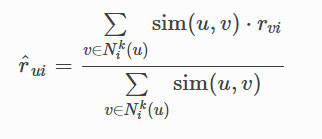




 Por eso obtenemos valores distintos. Sin embargo **si que la diferencia de valor entre su MAE y su RMSE obtenido es de,en torno al 0.2-0.3, igual que en nuestro caso.**

## **EJERCICIO OPCIONAL AÑADIDO**

Como ejercicio opcional propuesto en clase, vamos a comprobar la versión alternativa del KNN basado en usuario, en el que NO centramos los scores en la media, afecta a las métricas, en concreto a Precision y Recall. Vamos a ver si tienen un efecto relevante en las recomendaciones.

En la propuesta origianl usábamos:
  $$\hat{r}(u,x) =\bar{r}(u)+c \sum_{v \in \eta_k(u)} sim(u,v)(r(v,x)-\bar{r}(v))$$ 

Ahora ya no centramos el rating para un usuario en su propia media, ni corregiremos los ratings de los vecinos restándole su desviación estándar. De modo que el score de recomendación de un item para un usuario queda tal que:

  $$\hat{r}(u,x) =c \sum_{v \in \eta_k(u)} sim(u,v)r(v,x)$$ 


Usando la similitud coseno por proporcionar resultados similares que la similitud de Pearson, repetimos el ejercicio 3, sin usar la constante de normalización para calcular los scores de los items:

In [27]:
k = 7
N_item_to_recommed = 5
user_KNN( mat_train, sim_fun = 'cos' ).call_precision_recall(mat_test, k=k ,rel_score_min = 3, n = N_item_to_recommed, verbosse = True,  norm = False)

Precision: 0.044444444444444446
Recall: 0.07407407407407407
	Sim function: cos
	k =  7


In [28]:
k = 7
N_item_to_recommed = 8
user_KNN( mat_train, sim_fun = 'cos' ).call_precision_recall(mat_test, k=k ,rel_score_min = 3, n = N_item_to_recommed, verbosse = True,  norm = False)

Precision: 0.06944444444444445
Recall: 0.17592592592592593
	Sim function: cos
	k =  7


In [29]:
k = 7
N_item_to_recommed = 10
user_KNN( mat_train, sim_fun = 'cos' ).call_precision_recall(mat_test, k=k ,rel_score_min = 3, n = N_item_to_recommed, verbosse = True,  norm = False)

Precision: 0.06666666666666667
Recall: 0.2037037037037037
	Sim function: cos
	k =  7


In [30]:
k = 7
N_item_to_recommed = 15
user_KNN( mat_train, sim_fun = 'cos' ).call_precision_recall(mat_test, k=k ,rel_score_min = 3, n = N_item_to_recommed, verbosse = True,  norm = False)

Precision: 0.05185185185185185
Recall: 0.2314814814814815
	Sim function: cos
	k =  7


In [31]:
k = 7
N_item_to_recommed = 20
user_KNN( mat_train, sim_fun = 'cos' ).call_precision_recall(mat_test, k=k ,rel_score_min = 3, n = N_item_to_recommed, verbosse = True,  norm = False)

Precision: 0.044444444444444446
Recall: 0.2592592592592593
	Sim function: cos
	k =  7


In [32]:
k = 7
N_item_to_recommed = 30
user_KNN( mat_train, sim_fun = 'cos' ).call_precision_recall(mat_test, k=k ,rel_score_min = 3, n = N_item_to_recommed, verbosse = True,  norm = False)

Precision: 0.040740740740740744
Recall: 0.37037037037037035
	Sim function: cos
	k =  7


Observamos resultados similares, por lo que podemos **afirmar que para este datset no mejoramos las métricas y centrando o no los ratings en la media de cada usuario.** Si observamos nuestro datset de ratings, a primera vista parece que es un síntoma de que las medias de nuestra valoraciones sobre películas ya están bastante equilibradas. Es muy probable que en un dataset de mayor tamaño, precision y recall empeoraran con esta última versión.